Using GPU


Scoring queries: 100%|██████████| 57/57 [01:37<00:00,  1.70s/query]
/tmp/ipykernel_3479111/3300377730.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([all_rel_scores, all_nonrel_scores],


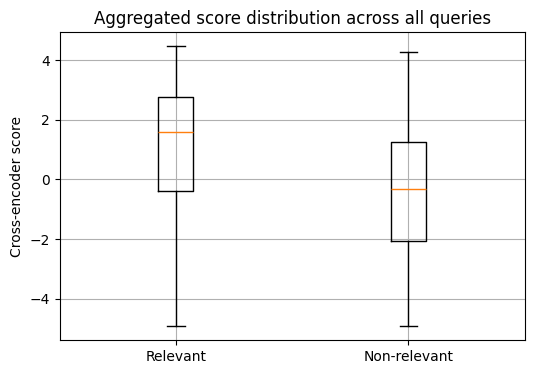

/tmp/ipykernel_3479111/3300377730.py:95: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(scores_by_query, labels=labels, showfliers=False)


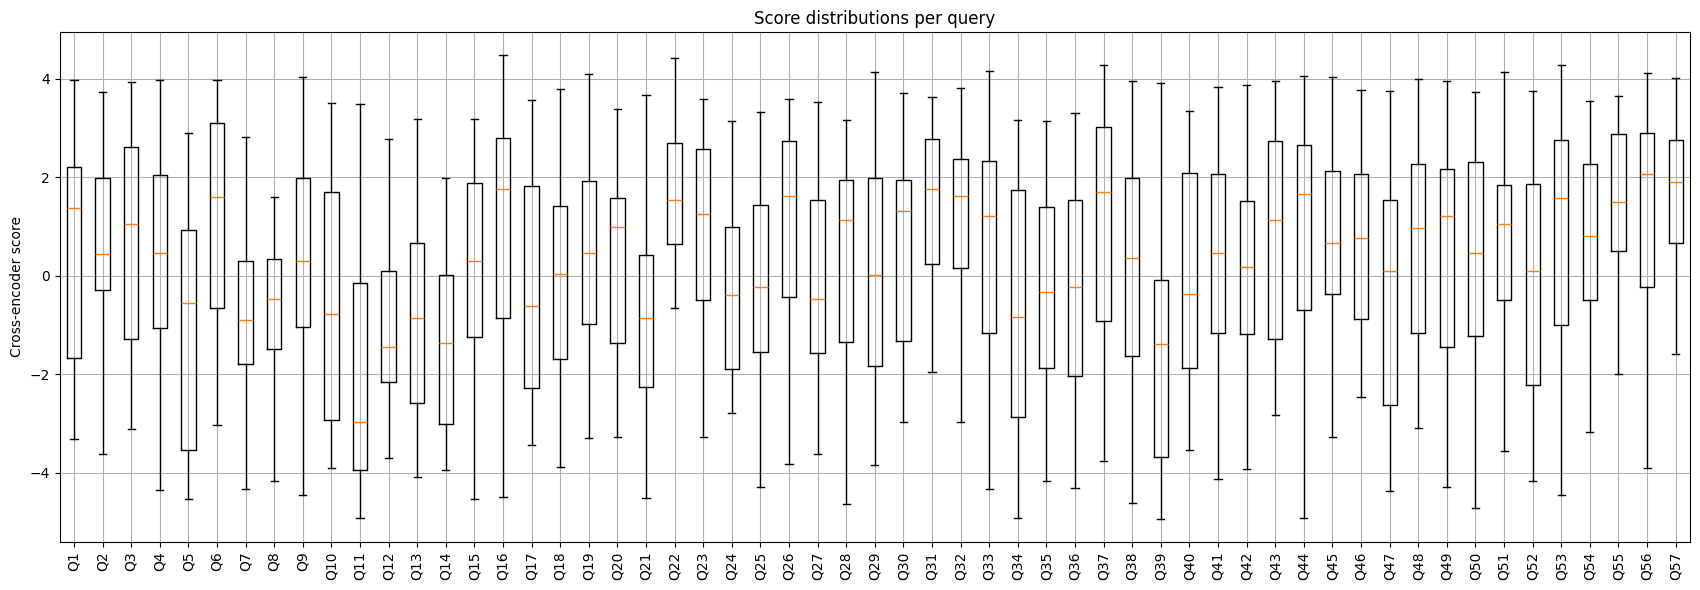

In [2]:
import os
import sys
sys.path.append(os.path.expanduser("~/tesis/messirve-ir"))
import json

import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from more_itertools import chunked

# allow imports from repo root
from src.utils.cross_encoder_scorer import CrossEncoderScorer
from config.config import STORAGE_DIR

# 1) Load cross‑encoder model and tokenizer
checkpoint_dir = "/media/discoexterno/leon/legal_ir/results/cross_encoder_lr_1e-05_ranknet/checkpoint-594"
result_dir = "/media/discoexterno/leon/legal_ir/results/cross_encoder_lr_1e-05_ranknet"
reranker_model = AutoModelForSequenceClassification.from_pretrained(checkpoint_dir)
if torch.cuda.is_available():
    print("Using GPU")
    reranker_model = reranker_model.to("cuda")
tokenizer = AutoTokenizer.from_pretrained(result_dir)
scorer = CrossEncoderScorer(reranker_model, tokenizer, head_type="ranknet")

# 2) Load qrels
qrels_path = '/media/discoexterno/leon/legal_ir/data/annotations/qrels_py.tsv'
qrels = pd.read_csv(qrels_path, sep="\t", header=None, names=["query_id", "_", "doc_id", "relevance"])
qrels["relevance"] = qrels["relevance"].astype(int)

# 3) Load corpus dictionary
corpus_path = os.path.join(STORAGE_DIR, "legal_ir", "data", "corpus", "corpus_Gpt4o-mini_cleaned.json")
with open(corpus_path, 'r', encoding='utf-8') as f:
    corpus_dict = json.load(f)
df_corpus = pd.DataFrame(list(corpus_dict.items()), columns=["Codigo", "text"])
id_to_doc = dict(zip(df_corpus["Codigo"].tolist(), df_corpus["text"].tolist()))

# 4) Load queries list
queries_csv = os.path.join(STORAGE_DIR, "legal_ir", "data", "corpus", "queries_57.csv")
queries_df = pd.read_csv(queries_csv)
queries = queries_df["Query"].tolist()

# 5) Score & aggregate for all queries
all_rel_scores = []
all_nonrel_scores = []
scores_by_query = []
labels = []

for qid in tqdm(sorted(qrels["query_id"].unique()),
                  desc="Scoring queries", unit="query", total=len(qrels["query_id"].unique())):
    # get the text of this query
    query_text = queries[qid - 1]  # adjust index if necessary

    # get doc IDs and texts for this query
    qrels_q = qrels[qrels["query_id"] == qid]
    doc_ids_q = qrels_q["doc_id"].tolist()
    docs_q = [id_to_doc[str(d)] for d in doc_ids_q]

    batch_size = 16
    sc = []
    for docs_batch in tqdm(
        chunked(docs_q, batch_size),
        desc=f"Scoring Q{qid}",
        leave=False,
        unit="batch"
    ):
        batch_queries = [query_text] * len(docs_batch)
        sc_batch = scorer.score(batch_queries, docs_batch, max_length=2048)
        sc.extend(sc_batch)

    # get relevance labels
    rel_map = qrels_q.set_index("doc_id")["relevance"]
    rels = [rel_map[d] for d in doc_ids_q]

    # accumulate global lists
    all_rel_scores += [s for s, r in zip(sc, rels) if r >= 2]
    all_nonrel_scores += [s for s, r in zip(sc, rels) if r <= 1]

    # keep per-query scores
    scores_by_query.append(sc)
    labels.append(f"Q{qid}")

# 6) Plot aggregated boxplot
plt.figure(figsize=(6, 4))
plt.boxplot([all_rel_scores, all_nonrel_scores],
            labels=["Relevant", "Non-relevant"])
plt.title("Aggregated score distribution across all queries")
plt.ylabel("Cross‑encoder score")
plt.grid(True)
plt.show()

# 7) Plot per‑query boxplots
plt.figure(figsize=(max(8, len(labels) * 0.3), 6))
plt.boxplot(scores_by_query, labels=labels, showfliers=False)
plt.xticks(rotation=90)
plt.title("Score distributions per query")
plt.ylabel("Cross‑encoder score")
plt.grid(True)
plt.tight_layout()
plt.show()


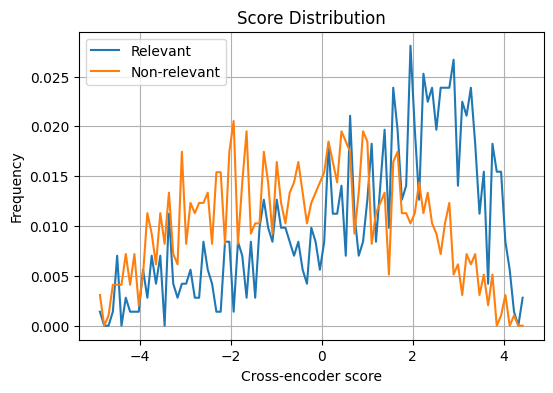

In [6]:
import numpy as np

# 8) Plot distribution line plot of aggregated scores
plt.figure(figsize=(6, 4))
# define bins across the full score range
min_score = min(all_rel_scores + all_nonrel_scores)
max_score = max(all_rel_scores + all_nonrel_scores)
bins = np.linspace(min_score, max_score, 100)
# compute histograms
rel_hist, _ = np.histogram(all_rel_scores, bins=bins)
nonrel_hist, _ = np.histogram(all_nonrel_scores, bins=bins)
# normalize
rel_hist = rel_hist / rel_hist.sum()
nonrel_hist = nonrel_hist / nonrel_hist.sum()
# bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, rel_hist, label="Relevant")
plt.plot(bin_centers, nonrel_hist, label="Non-relevant")
plt.title("Score Distribution")
plt.xlabel("Cross‑encoder score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

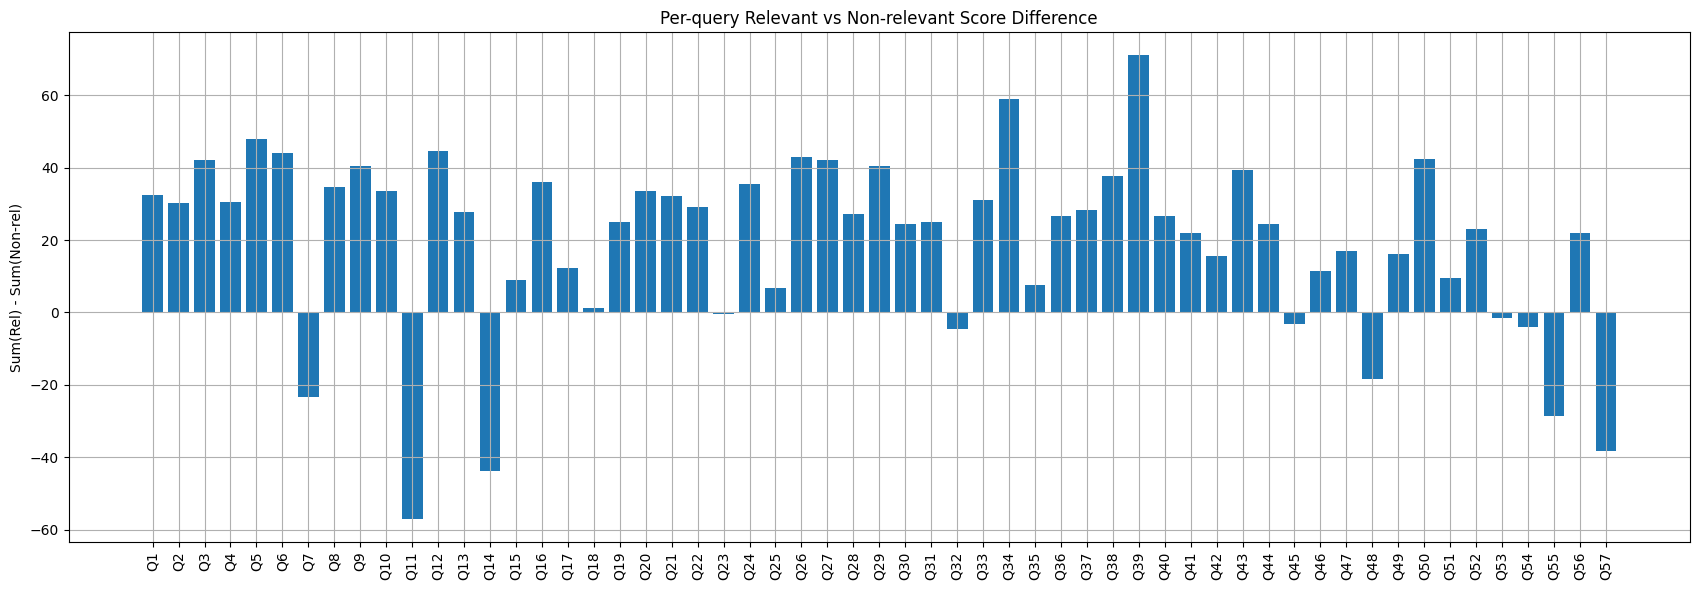

In [11]:
# 9) Per-query difference bar plot
query_ids = sorted(qrels["query_id"].unique())
query_diffs = []
for sc, qid in zip(scores_by_query, query_ids):
    qrels_q = qrels[qrels["query_id"] == qid]
    rel_map = qrels_q.set_index("doc_id")["relevance"]
    rel_sum = sum(s for s, d in zip(sc, qrels_q["doc_id"].tolist()) if rel_map[d] >= 2)
    nonrel_sum = sum(s for s, d in zip(sc, qrels_q["doc_id"].tolist()) if rel_map[d] <= 1)
    query_diffs.append(rel_sum - nonrel_sum)

plt.figure(figsize=(max(8, len(labels) * 0.3), 6))
plt.bar(labels, query_diffs)
plt.xticks(rotation=90)
plt.title("Per-query Relevant vs Non-relevant Score Difference")
plt.ylabel("Sum(Rel) - Sum(Non-rel)")
plt.tight_layout()
plt.grid(True)
plt.show()

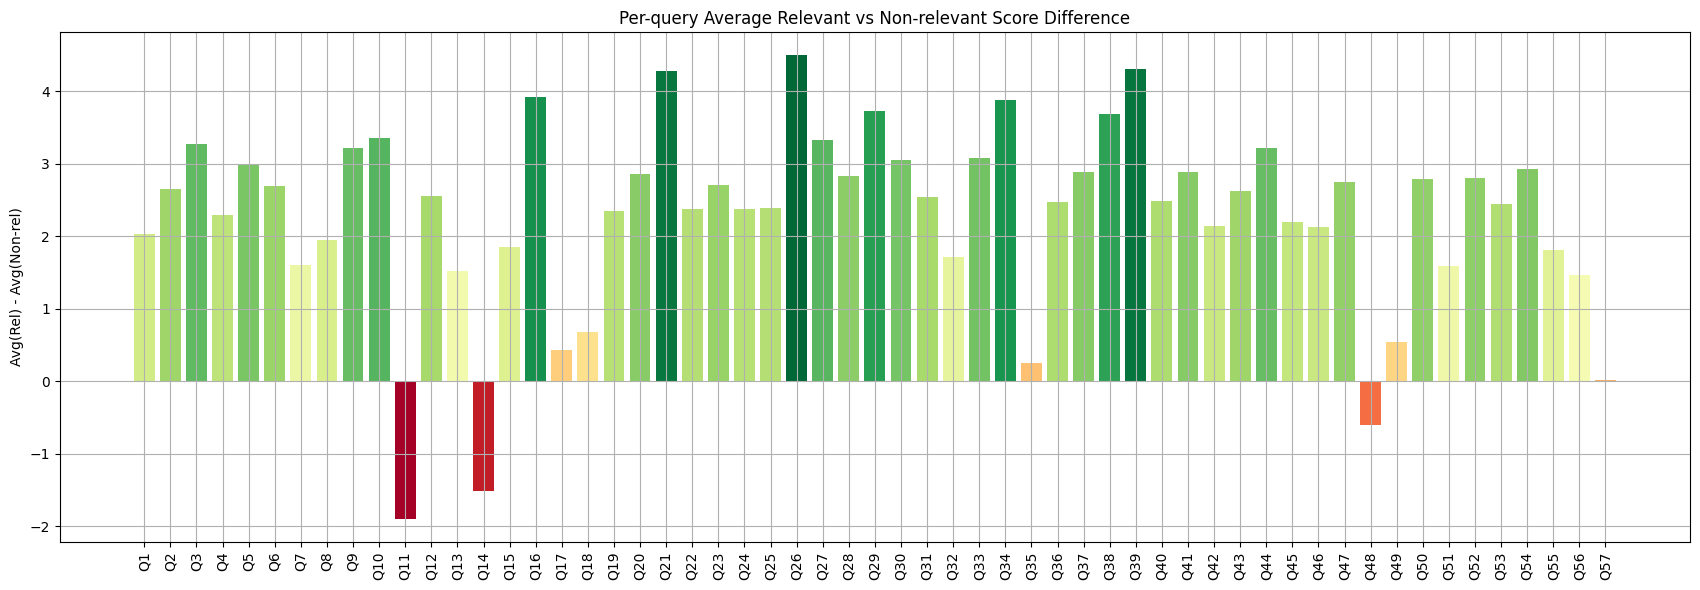

In [12]:
# 9) Per-query average difference bar plot
query_diffs = []
for sc, qid in zip(scores_by_query, query_ids):
    qrels_q = qrels[qrels["query_id"] == qid]
    rel_map = qrels_q.set_index("doc_id")["relevance"]
    rel_scores = [s for s, d in zip(sc, qrels_q["doc_id"].tolist()) if rel_map[d] >= 2]
    nonrel_scores = [s for s, d in zip(sc, qrels_q["doc_id"].tolist()) if rel_map[d] <= 1]
    rel_avg = sum(rel_scores) / len(rel_scores) if rel_scores else 0
    nonrel_avg = sum(nonrel_scores) / len(nonrel_scores) if nonrel_scores else 0
    query_diffs.append(rel_avg - nonrel_avg)

# color bars: red for negative, green for positive
norm = plt.Normalize(min(query_diffs), max(query_diffs))
cmap = plt.cm.RdYlGn
colors = cmap(norm(query_diffs))

plt.figure(figsize=(max(8, len(labels) * 0.3), 6))
plt.bar(labels, query_diffs, color=colors)
plt.xticks(rotation=90)
plt.title("Per-query Average Relevant vs Non-relevant Score Difference")
plt.ylabel("Avg(Rel) - Avg(Non-rel)")
plt.tight_layout()
plt.grid(True)
plt.show()

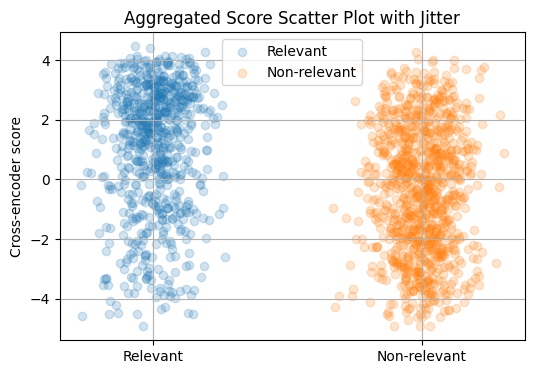

In [22]:
plt.figure(figsize=(6, 4))
jitter_strength = 0.1
x_rel = np.random.normal(0, jitter_strength, size=len(all_rel_scores))
x_nonrel = np.random.normal(1, jitter_strength, size=len(all_nonrel_scores))
plt.scatter(x_rel, all_rel_scores, alpha=0.2, label="Relevant")
plt.scatter(x_nonrel, all_nonrel_scores, alpha=0.2, label="Non-relevant")
plt.xticks([0, 1], ["Relevant", "Non-relevant"])
plt.title("Aggregated Score Scatter Plot with Jitter")
plt.ylabel("Cross‑encoder score")
plt.legend()
plt.grid(True)
plt.show()


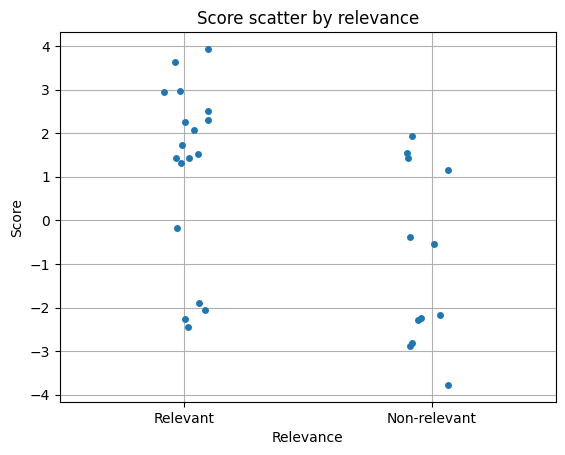

In [5]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame({
    "Score": scores,
    "Relevance": ["Relevant" if r >= 2 else "Non-relevant" for r in relevances]
})

sns.stripplot(data=df, x="Relevance", y="Score", jitter=True)
plt.title("Score scatter by relevance")
plt.grid(True)
plt.show()

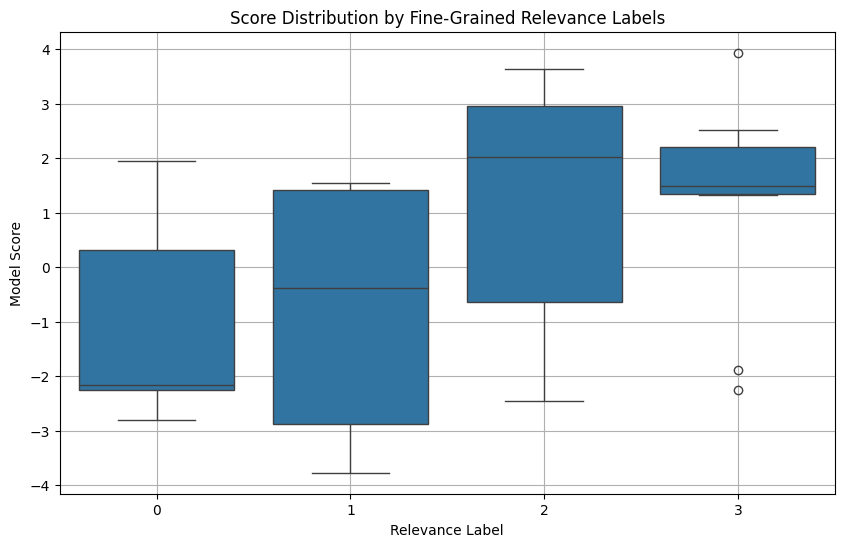

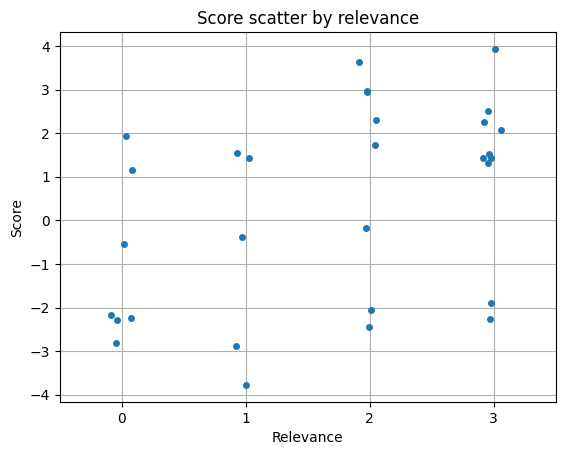

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame with your scores and their fine-grained relevance labels
df = pd.DataFrame({
    "Score": scores,
    "Relevance": relevances  # Each value here is expected to be 0, 1, 2, or 3
})

# Set the figure size for clarity
plt.figure(figsize=(10, 6))

# Plot a boxplot showing the score distribution for each relevance label
sns.boxplot(x="Relevance", y="Score", data=df, order=[0, 1, 2, 3])
plt.title("Score Distribution by Fine-Grained Relevance Labels")
plt.xlabel("Relevance Label")
plt.ylabel("Model Score")
plt.grid(True)
plt.show()

sns.stripplot(data=df, x="Relevance", y="Score", jitter=True)
plt.title("Score scatter by relevance")
plt.grid(True)
plt.show()
